In [73]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import plotly.express as px
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Consideramos el siguiente dataset con características de automóviles e intentaremos crear un modelo de regresión que prediga el MPG (millas por galón) apartir de variables como, horsepower, weight y acceleration.

In [74]:
path="data/auto-mpg.data"
df = pd.read_csv(path,delim_whitespace=True,index_col="car_name",na_values="?",names=[
                         "MPG", "cylinders", "displacement", "horsepower",
                         "weight", "acceleration", "model year", "origin",
                         "car_name"])
df = df.dropna()

### Primero realizamos los gráficos de dispersión y vemos que para el gráfico MPG vs peso existe una relación hiperbólica, lo que nos hace pensar que un ajuste lineal no será útil, si no mas bien un ajuste polinomial. Para el gráfico MPG vs aceleración vemos que existe una dependecia muy ruidosa, sin una tendencia clara, lo que será difícil de ajustar. Finalmete para el gráfico MPG vs caballos de fuerza vemos una relación muy parecida a la del primer gráfico, osea hiperbólica.

In [75]:
df_plot = df.reset_index()
df_plot = df_plot[['MPG','horsepower','weight','acceleration']]
df_plot.index = df['MPG']
df_plot = df_plot.drop(['MPG'], axis=1)
px.scatter(df_plot)

### Primero ajustamos un modelo de regresión lineal para predecir MPG en función del peso, los caballos de fuerza y la aceleración.

In [76]:
Y = df["MPG"]
X = df[["weight", "acceleration", "horsepower"]]
X = sm.add_constant(X)
model = sm.OLS(Y, X)
result = model.fit()

### En base al estadístico t, se rechaza la hipótesis de que los parámetro asociados a los caballos de fuerza, el peso y la constante son nulos. No hay suficiente evidencia para rechazar en el caso de la aceleración.

In [77]:
result.summary(alpha=0.05)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    MPG   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     311.1
Date:                Sun, 02 Apr 2023   Prob (F-statistic):          7.48e-103
Time:                        15:51:41   Log-Likelihood:                -1121.0
No. Observations:                 392   AIC:                             2250.
Df Residuals:                     388   BIC:                             2266.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           45.6783      2.409     18.965      0.000      40.943      50.414
weight          -0.0058      0.001    -10.024      0.000      -0.007      -0.005
acceleration    -0.0021      0.123     -0.017      0.987      -0.245       0.240
horsepower      -0.0475      0.016     -2.970      0.003      -0.079      -0.016
==============================================================================
Omnibus:                       35.392   Durbin-Watson:                   0.858
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.071
Skew:                           0.684   Prob(JB):                     9.91e-11
Kurtosis:                       3.975   Cond. No.                     3.48e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.48e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Creamos un modelo de Regreasión de input la variables "Horsepower" y "Weight", y el output "MPG"

In [78]:
y = df["MPG"].to_numpy()
x = df[["horsepower",'weight']].to_numpy().reshape(-2, 2)

### Probamos con diferentes grados de polinomios y calculamos el error de cada uno utilizando validación cruzada y error cuadratico medio

In [79]:
scorer = make_scorer(mean_squared_error)
val_scores = []
train_scores = []
grados = np.arange(1, 11, step=1)

for grado in grados:
   
    model = make_pipeline(PolynomialFeatures(grado), LinearRegression(fit_intercept=False))    
    val_scores.append(cross_val_score(model, x, y, cv=5, scoring=scorer))
    model.fit(x, y)
    train_scores.append(scorer(model,x, y))

score_mean = [score.mean() for score in val_scores]
print("El polinomio con menor error de validacion es: " +str(grados[np.argmin(score_mean)]))

El polinomio con menor error de validacion es: 2


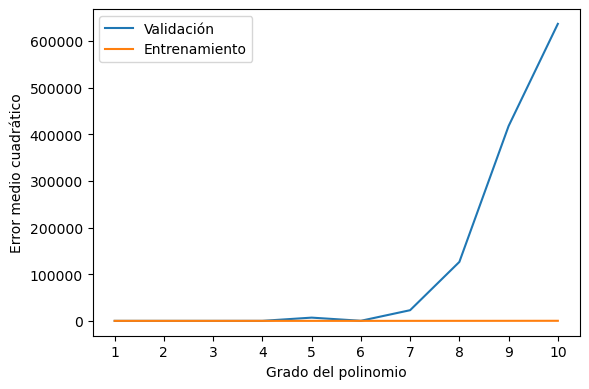

In [80]:
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
ax.plot(np.arange(1, len(score_mean)+1), score_mean, label='Validación')
ax.plot(np.arange(1, len(train_scores)+1), train_scores, label='Entrenamiento')

ax.set_xticks(range(1, 11))
plt.legend()
ax.set_xlabel('Grado del polinomio')
ax.set_ylabel('Error medio cuadrático');

In [81]:
model = make_pipeline(PolynomialFeatures(degrees[np.argmin(score_mean)]), LinearRegression(fit_intercept=False))
model.fit(x, y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression(fit_intercept=False))])

In [82]:
X_grid = np.linspace(min(x[:,0]), max(x[:,0]), num=100)
Y_grid = np.linspace(min(x[:,1]), max(x[:,1]), num=100)
X,Y = np.meshgrid(X_grid,Y_grid)
X,Y = X.flatten(), Y.flatten()
Z = np.column_stack((X, Y)).reshape(-2, 2)

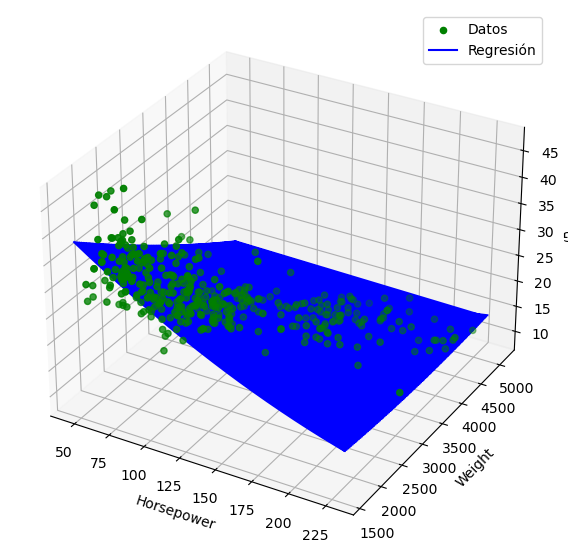

In [83]:
fig = plt.figure(figsize = (15, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(x[:,0], x[:,1],y,color = "green",label="Datos")
ax.plot3D(X,Y, model.predict(Z),color = "blue",label="Regresión")
ax.set_xlabel("Horsepower")
ax.set_ylabel("Weight")
ax.set_zlabel("MPG", rotation=180)
ax.legend()
plt.show()